## Project milestone 1
This jupyter notebook is to recode all the steps I did for the project! <br>
Basically, this project is a classification problem to predict whether a defendant is guilty or not.

First, let us better understand what are these different features representation of the text <br>
1. bag-of-word: this is the statistics of the appearance of a word in the article
2. tl-idf: is the product of two statistics: term-frequency and inverse document frequency. Therefore, this is more
representative than the first one
3. Glove is launched by Stanford to give the vector representation of a word

In [108]:
# first, we load the libsvm data format
import numpy as np
import pandas as pd

def load_file(file, col_names):
    count =0
    label = []
    feature = []
    with open(file, 'r') as myfile:
        Lines = myfile.readlines()
        for line in Lines:
            count += 1
            #print("Line{}: {}".format(count, line.strip()))
            line_str = line.strip()
            label.append(line_str.split(" ", 1)[0])
            feature_str = '{'+line_str.split(" ", 1)[1]+'}'
            feature_str = feature_str.replace(' ',',')
            feature.append(eval(feature_str))
        # Then we convert label and features into numpy and pandas dataframe
        label = np.array(label).astype('int')
        label = np.where(label == 0, -1, label)
        feature = pd.DataFrame(feature)
        feature[len(col_names) + 1] = 1
        feature = feature.to_numpy()
    return label, feature

In [109]:
# in this milestone, we use the GloVe representation cause it is dense.
# Therefore, we prepare the data
col_names = [str(i) for i in range(1, 301, 1)]
train_label, train_feature = load_file("project_data/data/glove/glove.train.libsvm", col_names)
test_label, test_feature = load_file("project_data/data/glove/glove.test.libsvm", col_names)
_, eval_feature = load_file("project_data/data/glove/glove.eval.anon.libsvm", col_names)

In [110]:
# check the info
print(len(train_label), train_feature.shape)
print(len(test_label), test_feature.shape)
print(eval_feature.shape)
print(train_feature.dtype)
print(train_label)

17500 (17500, 301)
2250 (2250, 301)
(5250, 301)
float64
[-1 -1  1 ...  1 -1  1]


In [115]:
# Since right now, we have a fairly large we can split the training data in to 10 groups
train_label_folds = []
train_feature_folds = []
k = 5
train_label_folds.extend(np.array_split(train_label, k))
train_feature_folds.extend(np.array_split(train_feature, k))

# check the size
print(len(train_label_folds))
print(len(train_feature_folds))
print(train_feature_folds[0])

5
5
[[-0.37321582 -0.43813774 -0.710158   ...  0.17964305  0.22722556
   1.        ]
 [-0.3436798   0.45484513  0.3770037  ... -0.94347286 -0.10640071
   1.        ]
 [ 0.12147348  0.7027245  -0.60731876 ... -0.21229324  0.13581502
   1.        ]
 ...
 [-0.3166688   0.23211712 -0.7034404  ...  0.5755391   0.19372928
   1.        ]
 [-0.10182871  0.5574947   0.04862087 ... -0.72511405  0.15029608
   1.        ]
 [-0.02936041 -0.00777097 -0.1682461  ... -0.52307725  0.13668457
   1.        ]]


In [319]:
# predict and accuracy
def accuracy(weights, feature, label):
    # predict the result
    res = feature @ weights
    res[res >= 0] = 1
    res[res < 0] = -1
    #print(res.shape)
    #print(np.shape(res == label))
    acc = np.sum(res == label) / feature.shape[0]
    return acc

# Here we implement the last classifier
def percep_avg(feature, label, learning_rate, epochs):
    # initialize weights with random number in the range (-0.01, 0.01)
    np.random.seed(42)
    updates  = 0
    num = feature.shape[1]
    w = np.random.uniform(-1, 1, size=(num,))
    avg = np.zeros((num,))
    avgs = []
    accs = []
    # perceptron algorithm
    for epoch in range(epochs):
        print("During the %d epoch!!" % (epoch+1))
        # shuffle the feature and label accordingly
        # use the shape[0] to shuffle these two arrays
        s = np.arange(feature.shape[0])
        np.random.shuffle(s)
        shuffled_feature = feature[s]
        shuffled_label = label[s]
        # predict and update the w accordingly
        for i, x in enumerate(shuffled_feature):
            y = shuffled_label[i]
            if y*(x @ w) <= 0:
                # we update the w with learning rate*x
                w += learning_rate/(1 + epoch)*y*x
                updates += 1
            # we add the weights to the avg
            avg += w
        acc = accuracy(avg, feature, label)
        accs.append(acc)
        avgs.append(avg)
        print("The training accuracy at %d epoch is %f." % (epoch+1, acc))
        print("Finish the %d epoch" % (epoch+1))
    return avg, updates, accs, avgs

In [125]:
# step1: cross_validation
# we iterate through each depth and each fold as the validation set
learning_rates = [1, 0.1, 0.01]
num_of_folds = len(train_feature_folds)
accs = np.zeros([len(learning_rates), num_of_folds])

for j,lr in enumerate(learning_rates):
    for i in range(num_of_folds):
        print("We are doing the cross_validation on lr: %f and the %d group as validation set!" % (lr, i+1))
        train_concat_features = np.concatenate([train_feature_folds[j] for j in range(num_of_folds) if j != i])
        train_concat_labels = np.concatenate([train_label_folds[j] for j in range(num_of_folds) if j != i])
        avg, updates, _, _ = percep_avg(train_concat_features, train_concat_labels, lr, epochs=20)
        acc = accuracy(avg, train_feature_folds[i], train_label_folds[i])
        accs[j][i] = acc

print("Finished!")

print(accs)
avg_accs = np.mean(accs, axis=1)
stds = np.std(accs, axis=1)
for i in range(len(learning_rates)):
    print("The average cross-validated accuracy with learning rate %f is %f" % (learning_rates[i], avg_accs[i]))
    print("The average cross-validated std with learning rate %f is %f" % (learning_rates[i], stds[i]))

# therefore, we choose the perceptron algorithm with lr = 1

We are doing the cross_validation on lr: 1.000000 and the 1 group as validation set!
During the 1 epoch!!
The training accuracy at 1 epoch is 0.652357.
Finish the 1 epoch
During the 2 epoch!!
The training accuracy at 2 epoch is 0.661286.
Finish the 2 epoch
During the 3 epoch!!
The training accuracy at 3 epoch is 0.663714.
Finish the 3 epoch
During the 4 epoch!!
The training accuracy at 4 epoch is 0.666071.
Finish the 4 epoch
During the 5 epoch!!
The training accuracy at 5 epoch is 0.666429.
Finish the 5 epoch
During the 6 epoch!!
The training accuracy at 6 epoch is 0.667143.
Finish the 6 epoch
During the 7 epoch!!
The training accuracy at 7 epoch is 0.667357.
Finish the 7 epoch
During the 8 epoch!!
The training accuracy at 8 epoch is 0.666500.
Finish the 8 epoch
During the 9 epoch!!
The training accuracy at 9 epoch is 0.666214.
Finish the 9 epoch
During the 10 epoch!!
The training accuracy at 10 epoch is 0.667143.
Finish the 10 epoch
During the 11 epoch!!
The training accuracy at 11 ep

During the 1 epoch!!
The training accuracy at 1 epoch is 0.652914.
Finish the 1 epoch
During the 2 epoch!!
The training accuracy at 2 epoch is 0.657086.
Finish the 2 epoch
During the 3 epoch!!
The training accuracy at 3 epoch is 0.658000.
Finish the 3 epoch
During the 4 epoch!!
The training accuracy at 4 epoch is 0.660800.
Finish the 4 epoch
During the 5 epoch!!
The training accuracy at 5 epoch is 0.662000.
Finish the 5 epoch
During the 6 epoch!!
The training accuracy at 6 epoch is 0.662457.
Finish the 6 epoch
During the 7 epoch!!
The training accuracy at 7 epoch is 0.663086.
Finish the 7 epoch
During the 8 epoch!!
The training accuracy at 8 epoch is 0.663543.
Finish the 8 epoch
During the 9 epoch!!
The training accuracy at 9 epoch is 0.663886.
Finish the 9 epoch
During the 10 epoch!!
The training accuracy at 10 epoch is 0.664000.
Finish the 10 epoch
During the 11 epoch!!
The training accuracy at 11 epoch is 0.663543.
Finish the 11 epoch
During the 12 epoch!!
The training accuracy at 1

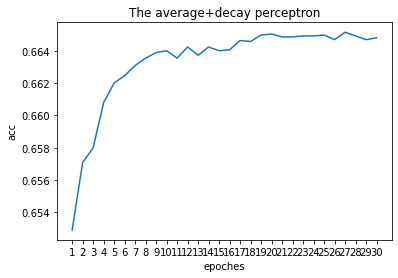

In [126]:
# train on the training data to find the best weight
# We use the best chosen learning rate to train on the full dataset
import matplotlib.pyplot as plt
%matplotlib inline
final_avg, updates, trained_accs, trained_avgs = percep_avg(train_feature, train_label, 0.1, epochs=30)
print("The total updates during the training is %d" % updates)
iterations = np.arange(1,31)
plt.plot(iterations, trained_accs)
plt.xticks(np.arange(1, 31, 1.0))
plt.xlabel("epoches")
plt.ylabel("acc")
plt.title("The average+decay perceptron")
plt.savefig("percep_avg.jpg")
plt.show()

In [128]:
# step 3: find the best acc with specific iteration
print(np.argmax(trained_accs))
print(np.max(trained_accs))
best_avg = trained_avgs[26]

# use the best trained w to predict the test datasets
acc = accuracy(best_avg, test_feature, test_label)
print("The testing on test dataset with the weights from the simple perceptron is %f" % acc)

26
0.6651428571428571
The testing on test dataset with the weights from the simple perceptron is 0.651111


In [324]:
# step 4: generate the result from the evaluate data set
# predict and accuracy
def predict(weights, feature):
    # predict the result
    res = feature @ weights
    res[res >= 0] = 1
    res[res < 0] = 0
    return pd.Series(res).astype(int)


In [144]:
df = pd.read_csv("project_data/data/eval.ids.txt", header=None)
df.columns = ["example_id"]
print(df.head())

label = predict(best_avg, eval_feature)
df["label"] = label
df.to_csv("eval1_percep_avg.csv", index=False)

   example_id
0           0
1           1
2           2
3           3
4           4


### Project MileStone #2
In this second milestone, we will try to discretize the data set in order to use the decision trees. And, we combine the
word data with the misc attribute data to build a more informative dataset.

In [1]:
import numpy as np
import pandas as pd

# first we load the misc attribute data and to do the corresponding data manipulation
# 1. check if there is any null data and replace with the mean value
# 2. convert the categorical data using the one-hot method through the get_dummies
# which is better for decision tree and perceptron algorithm training
train_misc_data = pd.read_csv("project_data/data/misc-attributes/misc-attributes-train.csv")
test_misc_data = pd.read_csv("project_data/data/misc-attributes/misc-attributes-test.csv")
eval_misc_data = pd.read_csv("project_data/data/misc-attributes/misc-attributes-eval.csv")
print(train_misc_data.head())
print(test_misc_data.head())
print(eval_misc_data.head())
print(train_misc_data.shape)
print(test_misc_data.shape)
print(eval_misc_data.shape)

  defendant_age defendant_gender  num_victims victim_genders offence_category  \
0            62           female            1           male            theft   
1            17             male            1           male            theft   
2     not known             male            1           male            theft   
3     not known             male            1           male            theft   
4            52             male            1         female            theft   

  offence_subcategory  
0      theftFromPlace  
1       pocketpicking  
2       pocketpicking  
3       simpleLarceny  
4       pocketpicking  
  defendant_age defendant_gender  num_victims victim_genders offence_category  \
0            54             male            1           male        deception   
1     not known             male            1         female            theft   
2            18             male            1           male            theft   
3            23             male            1

In [2]:
# here we data cleaning all these three datasets
print(eval_misc_data['offence_subcategory'].unique())
print(train_misc_data['offence_subcategory'].unique())

['grandLarceny' 'coiningOffences' 'infanticide' 'burglary'
 'theftFromPlace' 'simpleLarceny' 'rape' 'murder' 'wounding' 'receiving'
 'other' 'housebreaking' 'stealingFromMaster' 'pettyLarceny' 'robbery'
 'highwayRobbery' 'perjury' 'animalTheft' 'assault' 'mail' 'sodomy'
 'fraud' 'pocketpicking' 'returnFromTransportation' 'embezzlement'
 'bigamy' 'shoplifting' 'threateningBehaviour' 'indecentAssault'
 'concealingABirth' 'pervertingJustice' 'manslaughter' 'arson'
 'assaultWithIntent' 'libel' 'keepingABrothel' 'forgery' 'extortion'
 'kidnapping' 'gameLawOffence' 'religiousOffences' 'bankrupcy'
 'illegalAbortion' 'conspiracy' 'vagabond' 'taxOffences' 'seditiousLibel'
 'assaultWithSodomiticalIntent' 'riot' 'pettyTreason' 'seducingAllegiance'
 'seditiousWords' 'treason']
['theftFromPlace' 'pocketpicking' 'simpleLarceny' 'bigamy' 'housebreaking'
 'coiningOffences' 'grandLarceny' 'fraud' 'forgery' 'manslaughter'
 'stealingFromMaster' 'wounding' 'riot' 'rape' 'murder' 'embezzlement'
 'highwayRo

In [3]:
# replace the not known, four years as the most common age
clean_nums = {"defendant_age" : {"fifteen years old" : 15, "eighteen" : 18, "thirty six" : 36, "fourteen" : 14, "twelve years of age" : 12,
                                 "ten" : 10, "Fifteen" : 15, "sixteen" : 16, "17 years" : 17, "twelve" : 12, "13 years":13,
                                 "eleven" : 11, "sixty-eight years":68, "sixty-three years of age":63, "seventeen years" : 17,
                                 "fifty" : 50, " (24)" : 24, " (26)" : 26, "thirteen": 13, "about 11 years age":11,
                                 "fifteen":15, "Thirteen":13, "twenty":20, "Fourscore years":18, "not known":18}}
train_misc_data.replace(clean_nums, inplace=True)
print(train_misc_data['defendant_age'].value_counts())
print(train_misc_data['defendant_age'].unique())
train_misc_data['defendant_age'].astype("int64")

18    9588
18     438
20     433
19     424
21     392
      ... 
68       1
85       1
79       1
77       1
10       1
Name: defendant_age, Length: 89, dtype: int64
['62' '17' 18 '52' '40' '30' '23' '60' '61' '49' '53' '34' '21' '28' '24'
 '22' '33' '27' '19' '37' '47' '44' '26' '59' '38' '54' '18' '51' '20' 15
 '25' '46' '13' '29' '39' '32' 14 '35' '16' '58' '31' '36' 12 '45' '43'
 '55' '57' '14' '77' '41' '15' '79' 10 '66' '42' '48' '69' '75' '50' '12'
 '65' '72' '11' '63' '64' '67' '10' '70' '85' '56' '68' 16 17 '9' '73' '8'
 13 11 68 63 '74' 36 50 24 26 '71' 20 '76' '89']


0        62
1        17
2        18
3        18
4        52
         ..
17495    18
17496    18
17497    18
17498    18
17499    18
Name: defendant_age, Length: 17500, dtype: int64

In [4]:
print(test_misc_data['defendant_age'].value_counts())
clean_nums_test = {"defendant_age" : {"thirteen":13, "seventeen":17, "Ten":10, "sixteen":16, "not known":23}}
test_misc_data.replace(clean_nums_test, inplace=True)
test_misc_data['defendant_age'].astype("int64")

not known    1217
23             58
22             55
20             51
19             46
             ... 
59              1
thirteen        1
69              1
63              1
Ten             1
Name: defendant_age, Length: 65, dtype: int64


0       54
1       23
2       18
3       23
4       23
        ..
2245    28
2246    28
2247    23
2248    37
2249    23
Name: defendant_age, Length: 2250, dtype: int64

In [5]:
print(eval_misc_data['defendant_age'].unique())
print(eval_misc_data['defendant_age'].value_counts())
clean_nums_eval = {"defendant_age" : {"thirteen years of age":13, "m":18, "about 14":14, "83d Year of his Age":83,
                                      "not known":18, "nine":9, "fifteen": 15, "eleven years old and six months":11,
                                      "14 years of age":14, "twelve":12, "ten":10, "seventeen":17, "11 or 12":12}}
eval_misc_data.replace(clean_nums_eval, inplace=True)
eval_misc_data['defendant_age'].astype("int64")

['not known' '26' '78' '31' '24' '41' '28' '52' '21' '33' '19' '18' '25'
 '16' '48' '15' '34' '45' '38' '12' '17' '22' '23' '35' '32' '14' '50'
 '20' '40' '13' '29' '39' '11' '37' '30' '27' '58' '43' '59' '75' '47'
 '62' '51' '36' '63' '42' '54' 'm' '46' '60' '53' '44' '64' '49'
 'thirteen years of age' '57' '69' 'about 14' '56' '83d Year of his Age'
 '76' '65' '55' '67' 'nine' 'fifteen' 'eleven years old and six months'
 '61' '66' '10' '68' '88' '71' '14 years of age' 'twelve' 'seventeen' '70'
 'ten' '11 or 12' '72']
not known                          2856
18                                  118
21                                  115
22                                  113
20                                  113
                                   ... 
11 or 12                              1
nine                                  1
88                                    1
eleven years old and six months       1
14 years of age                       1
Name: defendant_age, Length: 80, dty

0       18
1       26
2       18
3       18
4       18
        ..
5245    18
5246    18
5247    18
5248    26
5249    16
Name: defendant_age, Length: 5250, dtype: int64

In [6]:
train_misc_data[train_misc_data.isnull().any(axis=1)]

,defendant_age,defendant_gender,num_victims,victim_genders,offence_category,offence_subcategory
5,40,male,0,NaN,sexual,bigamy
8,30,male,0,NaN,royalOffences,coiningOffences
12,61,male,0,NaN,theft,theftFromPlace
15,49,male,0,NaN,deception,forgery
16,53,female,0,NaN,deception,forgery
...,...,...,...,...,...,...
17433,18,male,0,NaN,miscellaneous,other
17441,18,female,0,NaN,theft,housebreaking
17474,18,male,0,NaN,theft,grandLarceny
17496,18,male,0,NaN,theft,animalTheft


In [7]:
train_misc_data['victim_genders'].value_counts()
# replace the null as male
train_misc_data['victim_genders'].fillna('male', inplace=True)

In [8]:
test_misc_data[test_misc_data.isnull().any(axis=1)]

,defendant_age,defendant_gender,num_victims,victim_genders,offence_category,offence_subcategory
6,22,female,0,NaN,miscellaneous,concealingABirth
8,23,male,0,NaN,theft,grandLarceny
11,23,female,0,NaN,royalOffences,coiningOffences
26,23,male,0,NaN,deception,fraud
30,38,male,0,NaN,royalOffences,coiningOffences
...,...,...,...,...,...,...
2226,23,male,0,NaN,deception,perjury
2241,23,male,0,NaN,royalOffences,coiningOffences
2245,28,male,0,NaN,deception,forgery
2248,37,male,0,NaN,deception,forgery


In [9]:
test_misc_data['victim_genders'].value_counts()
test_misc_data['victim_genders'].fillna('male', inplace=True)

In [10]:
eval_misc_data[eval_misc_data.isnull().any(axis=1)]

,defendant_age,defendant_gender,num_victims,victim_genders,offence_category,offence_subcategory
1,26,male,0,NaN,royalOffences,coiningOffences
3,18,female,0,NaN,kill,infanticide
32,18,male,0,NaN,deception,perjury
43,18,male,0,NaN,deception,perjury
56,26,male,0,NaN,royalOffences,coiningOffences
...,...,...,...,...,...,...
5231,23,male,0,NaN,deception,fraud
5237,18,male,0,NaN,deception,perjury
5240,31,male,0,NaN,royalOffences,coiningOffences
5241,18,male,0,NaN,royalOffences,coiningOffences


In [11]:
eval_misc_data['victim_genders'].value_counts()
eval_misc_data['victim_genders'].fillna('male', inplace=True)

In [12]:
print(train_misc_data['victim_genders'].unique())
print(test_misc_data['victim_genders'].unique())
print(eval_misc_data['victim_genders'].unique())

['male' 'female' 'female;female' 'male;male' 'male;male;male'
 'male;male;male;male' 'indeterminate' 'male;female'
 'male;male;male;male;male' 'male;male;male;male;male;male' 'female;male'
 'male;male;male;male;male;male;male;male' 'male;female;female'
 'male;indeterminate' 'female;female;female;male' 'female;male;male'
 'male;female;male' 'male;male;female' 'female;female;male'
 'indeterminate;male;male' 'indeterminate;male' 'male;male;male;female'
 'female;female;female' 'female;female;female;female'
 'female;female;female;female;female' 'male;male;male;male;male;male;male'
 'female;male;male;female;male' 'male;male;indeterminate'
 'indeterminate;indeterminate' 'female;male;female'
 'male;male;male;male;male;male;male;indeterminate;indeterminate'
 'male;male;female;female;female'
 'indeterminate;male;male;male;male;male;male;male;indeterminate'
 'female;indeterminate;male;male'
 'male;male;male;male;male;indeterminate;male' 'female;male;female;male'
 'male;male;male;male;male;male;ma

In [13]:
data_sets = [train_misc_data, test_misc_data, eval_misc_data]
def encoding(data_sets, col_name):
    for data in data_sets:
        data[col_name] = data[col_name].astype("category")
        data[col_name + "_cat"] = data[col_name].cat.codes


In [14]:
encoding(data_sets, "offence_category")

In [15]:
gender = dict(zip(train_misc_data['defendant_gender'].unique(), range(len(train_misc_data['defendant_gender'].unique()))))
for data in data_sets:
    data["defendant_gender"] = data["defendant_gender"].map(gender)

In [16]:
subcategory = dict(zip(train_misc_data['offence_subcategory'].unique(), range(len(train_misc_data['offence_subcategory'].unique()))))
print(subcategory)
for data in data_sets:
    data["offence_subcategory"] = data["offence_subcategory"].map(subcategory)

{'theftFromPlace': 0, 'pocketpicking': 1, 'simpleLarceny': 2, 'bigamy': 3, 'housebreaking': 4, 'coiningOffences': 5, 'grandLarceny': 6, 'fraud': 7, 'forgery': 8, 'manslaughter': 9, 'stealingFromMaster': 10, 'wounding': 11, 'riot': 12, 'rape': 13, 'murder': 14, 'embezzlement': 15, 'highwayRobbery': 16, 'libel': 17, 'other': 18, 'infanticide': 19, 'burglary': 20, 'shoplifting': 21, 'pettyLarceny': 22, 'animalTheft': 23, 'receiving': 24, 'assaultWithIntent': 25, 'seditiousLibel': 26, 'arson': 27, 'pettyTreason': 28, 'mail': 29, 'perjury': 30, 'returnFromTransportation': 31, 'sodomy': 32, 'concealingABirth': 33, 'indecentAssault': 34, 'robbery': 35, 'extortion': 36, 'assault': 37, 'assaultWithSodomiticalIntent': 38, 'pervertingJustice': 39, 'kidnapping': 40, 'seditiousWords': 41, 'gameLawOffence': 42, 'bankrupcy': 43, 'illegalAbortion': 44, 'keepingABrothel': 45, 'piracy': 46, 'threateningBehaviour': 47, 'taxOffences': 48, 'conspiracy': 49, 'seducingAllegiance': 50, 'treason': 51, 'religio

In [17]:
for data in data_sets:
    data.drop("offence_category", inplace=True, axis=1)

In [18]:
def encoding_victim(data):
    mask1 = data['victim_genders'] == 'male' # 1
    mask2 = data['victim_genders'] == 'female'
    mask3 = (~mask1) & (~mask2)
    data['victim_genders'][mask1] = 1
    data['victim_genders'][mask2] = 0
    data['victim_genders'][mask3] = 2

In [19]:
for data in data_sets:
    encoding_victim(data)

<ipython-input-18-d4d91b753eea>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['victim_genders'][mask1] = 1
<ipython-input-18-d4d91b753eea>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['victim_genders'][mask2] = 0
<ipython-input-18-d4d91b753eea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['victim_genders'][mask3] = 2


In [20]:
eval_misc_data['offence_subcategory'].iloc[713] = 53


/Users/yang/.conda/envs/pythonProject/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [21]:
train_misc_data = train_misc_data.astype(int)

In [22]:
test_misc_data = test_misc_data.astype(int)
eval_misc_data = eval_misc_data.astype(int)

In [23]:
print(train_misc_data.shape)
print(test_misc_data.shape)
print(eval_misc_data.shape)

(17500, 6)
(2250, 6)
(5250, 6)


In [24]:
# we load the other data set to make a combined dataset
def load_file2(file, num_features, miscdata):
    count =0
    label = []
    feature = []
    with open(file, 'r') as myfile:
        Lines = myfile.readlines()
        for line in Lines:
            count += 1
            #print("Line{}: {}".format(count, line.strip()))
            line_str = line.strip()
            label.append(line_str.split(" ", 1)[0])
            feature_str = '{'+line_str.split(" ", 1)[1]+'}'
            feature_str = feature_str.replace(' ',',')
            feature.append(eval(feature_str))
        # Then we convert label and features into numpy and pandas dataframe
        label = np.array(label).astype('int')
        label = np.where(label == 0, -1, label)
        feature = pd.DataFrame(feature)
        df = pd.concat([feature, miscdata], axis=1, ignore_index=True)
        df[num_features + 1] = 1
        df = df.to_numpy()
    return label, df


In [25]:
# combine with the misc dataset, we should have 306 features in total for Glove
num_features = 306
train_label, train_feature = load_file2("project_data/data/glove/glove.train.libsvm", num_features, train_misc_data)

In [26]:
test_label, test_feature = load_file2("project_data/data/glove/glove.test.libsvm", num_features, test_misc_data)
_, eval_feature = load_file2("project_data/data/glove/glove.eval.anon.libsvm", num_features, eval_misc_data)
print(train_feature.shape)
print(test_feature.shape)
print(eval_feature.shape)

(17500, 307)
(2250, 307)
(5250, 307)


In [27]:
# again we use the  previous average model to see if there is any progress
# Since right now, we have a fairly large we can split the training data in to 10 groups
train_label_folds = []
train_feature_folds = []
k = 5
train_label_folds.extend(np.array_split(train_label, k))
train_feature_folds.extend(np.array_split(train_feature, k))

# check the size
print(len(train_label_folds))
print(len(train_feature_folds))
print(train_feature_folds[0])

5
5
[[-3.73215820e-01 -4.38137740e-01 -7.10158000e-01 ...  0.00000000e+00
   7.00000000e+00  1.00000000e+00]
 [-3.43679800e-01  4.54845130e-01  3.77003700e-01 ...  1.00000000e+00
   7.00000000e+00  1.00000000e+00]
 [ 1.21473484e-01  7.02724500e-01 -6.07318760e-01 ...  1.00000000e+00
   7.00000000e+00  1.00000000e+00]
 ...
 [-3.16668800e-01  2.32117120e-01 -7.03440400e-01 ...  1.00000000e+01
   7.00000000e+00  1.00000000e+00]
 [-1.01828710e-01  5.57494700e-01  4.86208720e-02 ...  2.00000000e+00
   7.00000000e+00  1.00000000e+00]
 [-2.93604060e-02 -7.77097050e-03 -1.68246100e-01 ...  3.40000000e+01
   6.00000000e+00  1.00000000e+00]]


In [320]:
# step1: cross_validation
# we iterate through each depth and each fold as the validation set
learning_rates = [1, 0.1, 0.01]
num_of_folds = len(train_feature_folds)
accs = np.zeros([len(learning_rates), num_of_folds])

for j,lr in enumerate(learning_rates):
    for i in range(num_of_folds):
        print("We are doing the cross_validation on lr: %f and the %d group as validation set!" % (lr, i+1))
        train_concat_features = np.concatenate([train_feature_folds[j] for j in range(num_of_folds) if j != i])
        train_concat_labels = np.concatenate([train_label_folds[j] for j in range(num_of_folds) if j != i])
        avg, updates, _, _ = percep_avg(train_concat_features, train_concat_labels, lr, epochs=20)
        acc = accuracy(avg, train_feature_folds[i], train_label_folds[i])
        accs[j][i] = acc

print("Finished!")

print(accs)
avg_accs = np.mean(accs, axis=1)
stds = np.std(accs, axis=1)
for i in range(len(learning_rates)):
    print("The average cross-validated accuracy with learning rate %f is %f" % (learning_rates[i], avg_accs[i]))
    print("The average cross-validated std with learning rate %f is %f" % (learning_rates[i], stds[i]))

We are doing the cross_validation on lr: 1.000000 and the 1 group as validation set!
During the 1 epoch!!
The training accuracy at 1 epoch is 0.683857.
Finish the 1 epoch
During the 2 epoch!!
The training accuracy at 2 epoch is 0.696714.
Finish the 2 epoch
During the 3 epoch!!
The training accuracy at 3 epoch is 0.698929.
Finish the 3 epoch
During the 4 epoch!!
The training accuracy at 4 epoch is 0.703571.
Finish the 4 epoch
During the 5 epoch!!
The training accuracy at 5 epoch is 0.706786.
Finish the 5 epoch
During the 6 epoch!!
The training accuracy at 6 epoch is 0.708429.
Finish the 6 epoch
During the 7 epoch!!
The training accuracy at 7 epoch is 0.709357.
Finish the 7 epoch
During the 8 epoch!!
The training accuracy at 8 epoch is 0.710500.
Finish the 8 epoch
During the 9 epoch!!
The training accuracy at 9 epoch is 0.711286.
Finish the 9 epoch
During the 10 epoch!!
The training accuracy at 10 epoch is 0.711929.
Finish the 10 epoch
During the 11 epoch!!
The training accuracy at 11 ep

During the 1 epoch!!
The training accuracy at 1 epoch is 0.688114.
Finish the 1 epoch
During the 2 epoch!!
The training accuracy at 2 epoch is 0.696514.
Finish the 2 epoch
During the 3 epoch!!
The training accuracy at 3 epoch is 0.700514.
Finish the 3 epoch
During the 4 epoch!!
The training accuracy at 4 epoch is 0.702571.
Finish the 4 epoch
During the 5 epoch!!
The training accuracy at 5 epoch is 0.704171.
Finish the 5 epoch
During the 6 epoch!!
The training accuracy at 6 epoch is 0.705714.
Finish the 6 epoch
During the 7 epoch!!
The training accuracy at 7 epoch is 0.706229.
Finish the 7 epoch
During the 8 epoch!!
The training accuracy at 8 epoch is 0.706343.
Finish the 8 epoch
During the 9 epoch!!
The training accuracy at 9 epoch is 0.707371.
Finish the 9 epoch
During the 10 epoch!!
The training accuracy at 10 epoch is 0.707600.
Finish the 10 epoch
During the 11 epoch!!
The training accuracy at 11 epoch is 0.708571.
Finish the 11 epoch
During the 12 epoch!!
The training accuracy at 1

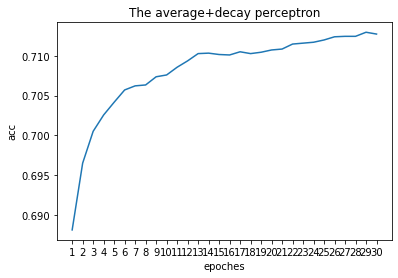

In [321]:
import matplotlib.pyplot as plt
%matplotlib inline
final_avg, updates, trained_accs, trained_avgs = percep_avg(train_feature, train_label, 1, epochs=30)
print("The total updates during the training is %d" % updates)
iterations = np.arange(1,31)
plt.plot(iterations, trained_accs)
plt.xticks(np.arange(1, 31, 1.0))
plt.xlabel("epoches")
plt.ylabel("acc")
plt.title("The average+decay perceptron")
plt.savefig("percep_avg.jpg")
plt.show()

In [323]:
# step 3: find the best acc with specific iteration
print(np.argmax(trained_accs))
print(np.max(trained_accs))
best_avg = trained_avgs[26]

# use the best trained w to predict the test datasets
acc = accuracy(best_avg, test_feature, test_label)
print("The testing on test dataset with the weights from the simple perceptron is %f" % acc)


28
0.7129714285714286
The testing on test dataset with the weights from the simple perceptron is 0.653333


In [325]:
df = pd.read_csv("project_data/data/eval.ids.txt", header=None)
df.columns = ["example_id"]
print(df.head())

label = predict(best_avg, eval_feature)
df["label"] = label
df.to_csv("eval2_percep_avg.csv", index=False)

   example_id
0           0
1           1
2           2
3           3
4           4


In [392]:
# we try to use decision trees
# because the Glove is continuous data, we need discritize it
# we load the other data set to make a combined dataset
def load_file3(file):
    count =0
    label = []
    feature = []
    with open(file, 'r') as myfile:
        Lines = myfile.readlines()
        for line in Lines:
            count += 1
            #print("Line{}: {}".format(count, line.strip()))
            line_str = line.strip()
            label.append(line_str.split(" ", 1)[0])
            feature_str = '{'+line_str.split(" ", 1)[1]+'}'
            feature_str = feature_str.replace(' ',',')
            feature.append(eval(feature_str))
        # Then we convert label and features into numpy and pandas dataframe
        label = np.array(label).astype('int')
        label = np.where(label == 0, -1, label)
        label = pd.Series(label)
        feature = pd.DataFrame(feature)
    return label, feature

In [393]:
train_label, train_feature = load_file3("project_data/data/glove/glove.train.libsvm")
test_label, test_feature = load_file3("project_data/data/glove/glove.test.libsvm")
_, eval_feature = load_file3("project_data/data/glove/glove.eval.anon.libsvm")

In [394]:
for i in range(1, 301, 1):
    train_feature[i] = pd.cut(train_feature[i], bins=2, labels=np.arange(2), right=False)
    test_feature[i] = pd.cut(test_feature[i], bins=2, labels=np.arange(2), right=False)
    eval_feature[i] = pd.cut(eval_feature[i], bins=2, labels=np.arange(2), right=False)

In [395]:
# combine this feature with misc data
# columns = np.arange(301, 307,1)
# train_misc_data.columns = columns
# test_misc_data.columns = columns
# eval_misc_data.columns = columns

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,1,0,1,1,1,1,0,1,0,0,...,1,0,1,1,0,1,1,1,1,1
1,1,0,1,1,1,1,1,1,1,0,...,1,0,1,1,1,1,0,1,0,0
2,1,1,1,1,1,1,1,1,0,0,...,1,0,1,0,0,1,1,1,0,1
3,0,1,1,0,1,0,1,0,1,0,...,1,0,0,1,1,0,1,0,1,0
4,1,0,1,1,1,1,1,1,1,0,...,1,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17495,1,0,1,0,1,1,1,1,1,0,...,1,0,0,1,0,1,0,1,0,0
17496,1,0,1,1,1,1,1,1,1,0,...,1,0,0,1,0,1,1,0,0,0
17497,1,0,1,0,1,1,0,1,1,0,...,1,0,0,1,1,1,1,1,0,1
17498,0,0,1,0,1,1,1,0,1,0,...,1,1,1,1,1,0,1,1,0,0


In [369]:
# train_feature = pd.concat([train_feature, train_misc_data], axis=1, ignore_index=True)
# train_feature

,0,1,2,3,4,5,6,7,8,9,...,296,297,298,299,300,301,302,303,304,305
0,2,0,2,2,2,2,1,2,1,0,...,2,2,2,2,62,0,1,1,0,7
1,2,1,3,2,2,2,2,2,2,0,...,1,2,0,1,17,1,1,1,1,7
2,2,2,2,2,3,2,2,2,1,0,...,2,2,1,2,18,1,1,1,1,7
3,1,2,2,1,2,1,2,1,2,1,...,2,1,2,1,18,1,1,1,2,7
4,2,1,3,2,2,2,2,2,2,0,...,2,2,1,1,52,1,1,0,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17495,2,1,3,1,2,2,2,2,2,0,...,1,2,1,1,18,1,1,1,0,7
17496,2,1,2,2,2,2,2,3,2,0,...,2,1,1,1,18,1,0,1,23,7
17497,2,1,2,1,2,2,1,2,2,1,...,2,2,1,2,18,1,1,1,4,7
17498,1,1,2,1,2,2,2,0,2,1,...,2,2,1,1,18,1,0,1,18,4


In [370]:
# test_feature = pd.concat([test_feature, test_misc_data], axis=1, ignore_index=True)
# eval_feature = pd.concat([eval_feature, eval_misc_data], axis=1, ignore_index=True)

In [396]:
train_label_folds = []
train_feature_folds = []
k = 5
train_label_folds.extend(np.array_split(train_label, k))
train_feature_folds.extend(np.array_split(train_feature, k))

# check the size
print(len(train_label_folds))
print(len(train_feature_folds))

5
5


In [397]:
# todo: define the node class to store the following
"""
1. feature
2. left / right node
3. label (class)
if this is a feature node then label is None;
if this is a label node then feature is None;
Because, for this particular dataset, for each feature, it is binary; therefore, we just use
the binary tree. Of course, for more than two values, we need to modify it.
"""
class Node:
    # we define the node data structure to store feature, left node, right node, label
    # if it is a feature node, then label should be None
    # if it is a label node, the feature should be None
    def __init__(self):
        self.feature = None # choose from the feature list [1, 2, ... , 123]
        # self.left = None
        # self.right = None
        # generalize this for more values for later use
        # because, there is possibility that we have more that binary values
        self.children = {}
        self.label = None # can only from [-1, 1] from the label set

# todo: define the ID3 algorithm
"""
1. deal with the boundary conditions:
    (a) all belong to one class then make that node as the label node
    (b) if there is no target feature left, we find the most occurred class as the label
2. calculate information gain for each feature and find the biggest one (need support functions)
{entropy, information gain, most_important-feature}
3. recursively build the tree (how to create is a very important step!!)
4. return the tree.
"""
"""
Based on the tree node we defined, we use a top-bottom method to write ID3 algorithm
input: feature dataset, label dataset, features set
notice: this three features will be updated when recursively called
output: tree node
"""
def is_unique(label_data):
    """
    :param label_data:
    :return: boolean whether the label dataset has the same value
    """
    label_array = label_data.to_numpy()
    return (label_array[0] == label_array).all()

def entropy(label_data):
    """
    :param label_data:
    :return: information entropy of corresponding labels under certain condition
    """
    labels = label_data.value_counts().to_list()
    entropy = np.sum([(-labels[i]/len(label_data)*np.log2(labels[i]/len(label_data))) for i in range(len(labels))])
    return entropy

def InfoGain(feature_data, label_data, feature, total_entropy):
    # find out what attribute can this feature take
    # in this case, values can only be 0 or 1
    # but later for generalization, values can take more than two values
    values = feature_data[feature].value_counts().index.to_list()
    weighted_entropy = np.sum([len(feature_data[feature_data[feature] == value])/len(feature_data) * entropy(label_data[feature_data[feature] == value]) for value in values])
    return total_entropy - weighted_entropy

def most_common(label_data):
    return label_data.value_counts().idxmax()

def ID3_pruned(feature_data, label_data, features, default, depth, level = 0):

    # the most commom feature from the previous dataset
    # if there is no data but still features
    if len(label_data) == 0:
        tree_node = Node()
        tree_node.label = default
        return tree_node
    # first deal with the boundary conditions
    # boundary condition 1: if the label has the same value
    if is_unique(label_data):
        # we assign the label to the tree node as a label node and return
        tree_node = Node()
        tree_node.label = label_data.value_counts().idxmax()
        return tree_node

    # boundary condition 2: if the features set is empty
    # or the tree level equals to the hyperparameter depth
    # if features is empty, it will return False in the if statement
    if (not features) or (level == depth): # True if the feature list is empty
        # find the most common label in and return as label node
        most_common_label = label_data.value_counts().idxmax()
        tree_node = Node()
        tree_node.label = most_common_label
        return tree_node
    else: # the normal case when the features list is not empty
        # find the feature for the current tree node
        # the information entropy of the current data set
        total_entropy = entropy(label_data)
        # we find the best feature for this tree node
        info_gains = [InfoGain(feature_data, label_data, feature, total_entropy) for feature in features]
        best_feature_index = np.argmax(info_gains)
        # print("the largest info gain is %f " % np.max(info_gains))
        best_feature = features[best_feature_index]
        tree_node = Node()
        # create a feature tree node
        tree_node.feature = best_feature
        tree_node.label = None

        # update the data set and feature set
        features = [i for i in features if i != best_feature]
        for value in feature_data[best_feature].value_counts().index.to_list():
            # print(value)
            new_feature_data = feature_data[feature_data[best_feature] == value]
            new_feature_data.drop(columns=best_feature)
            new_label_data = label_data[feature_data[best_feature] == value]
            # if best_feature == "40":
            #    print(tree_node.feature, value, new_label_data.value_counts())
            #    print(features)
            sub_tree = ID3_pruned(new_feature_data, new_label_data, features, most_common(feature_data), depth, level+1)
            # put the corresponding reuturn tree into the node
            tree_node.children[value] = sub_tree

        return tree_node

In [398]:
# To see how does the tree perform
def accuracy(trained_tree, test_features, test_label):
    """
    Parameters:
        trained_tree: A train tree
        test_features: the dataset of test feature
        test_label: the dataset of test label
    Returns:
        accuracy
    """
    # convert the dataframe to ndarray
    test_features = test_features.to_numpy()
    test_label = test_label.to_numpy()
    N = test_features.shape[0]
    print(N)

    # Set the counter to 0
    num_of_correct_predictions = 0

    for i in range(N):
        if predict(trained_tree, test_features[i]) == test_label[i]:
            num_of_correct_predictions += 1

    return num_of_correct_predictions / N


def predict(node, test_instance):
    """
    Parameters:
        node: A trained tree node
        test_instance: A single test instance
    Returns:
        predicted label
    """
    # Boundary Condition
    if len(node.children) == 0:
        return node.label
    else:
        # get corresponding value
        # value = test_instance[int(node.feature)]
        value = test_instance[int(node.feature) - 1]

        # Follow the tree to get the corresponding label of the test instance
        if value in node.children.keys():
            # Recursive call
            return predict(node.children[value], test_instance)

In [400]:
# we iterate through each depth and each fold as the validation set
features = [int(i) for i in range(1, 301, 1)]
depths = [1, 2, 3, 4, 5]
num_of_folds = len(train_feature_folds)
accs = np.zeros([len(depths), num_of_folds])

for depth in depths:
    for i in range(num_of_folds):
        print("We are doing the cross_validation on depth: %d and the %d group as validation set!" % (depth, i))
        train_concat_features = pd.concat([train_feature_folds[j] for j in range(num_of_folds) if j != i], ignore_index=True)
        train_concat_labels = pd.concat([train_label_folds[j] for j in range(num_of_folds) if j != i], ignore_index=True)
        tree = ID3_pruned(train_concat_features, train_concat_labels, features, most_common(train_concat_labels), depth=depth)
        acc = accuracy(tree, train_feature_folds[i], train_label_folds[i])
        accs[depth-1][i] = acc

print("Finished!")

We are doing the cross_validation on depth: 1 and the 0 group as validation set!
3500
We are doing the cross_validation on depth: 1 and the 1 group as validation set!
3500
We are doing the cross_validation on depth: 1 and the 2 group as validation set!
3500
We are doing the cross_validation on depth: 1 and the 3 group as validation set!
3500
We are doing the cross_validation on depth: 1 and the 4 group as validation set!
3500
We are doing the cross_validation on depth: 2 and the 0 group as validation set!
3500
We are doing the cross_validation on depth: 2 and the 1 group as validation set!
3500
We are doing the cross_validation on depth: 2 and the 2 group as validation set!
3500
We are doing the cross_validation on depth: 2 and the 3 group as validation set!
3500
We are doing the cross_validation on depth: 2 and the 4 group as validation set!
3500
We are doing the cross_validation on depth: 3 and the 0 group as validation set!
3500
We are doing the cross_validation on depth: 3 and the 

In [401]:
avg_accs = np.mean(accs, axis=1)
stds = np.std(accs, axis=1)
for i in range(len(depths)):
    print("The average cross-validated accuracy with depth %d is %f" % (i+1, avg_accs[i]))
    print("The average cross-validated std with depth %d is %f" % (i+1, stds[i]))

The average cross-validated accuracy with depth 1 is 0.536286
The average cross-validated std with depth 1 is 0.002342
The average cross-validated accuracy with depth 2 is 0.544000
The average cross-validated std with depth 2 is 0.007490
The average cross-validated accuracy with depth 3 is 0.550971
The average cross-validated std with depth 3 is 0.005863
The average cross-validated accuracy with depth 4 is 0.557200
The average cross-validated std with depth 4 is 0.004483
The average cross-validated accuracy with depth 5 is 0.562171
The average cross-validated std with depth 5 is 0.007586


In [402]:
# From the cross-validation, we choose the depth 3 as the hyperparameter to train on the whole dataset

full_tree = ID3_pruned(train_feature, train_label, features, most_common(train_label), depth=5)
train_acc_full = accuracy(full_tree, train_feature, train_label)
print("The train error on whole training set is %f" % (1-train_acc_full))
test_acc_full = accuracy(full_tree, test_feature, test_label)
print("The test error on whole test set is %f" % (1-test_acc_full))

17500
The train error on whole training set is 0.418629
2250
The test error on whole test set is 0.450667


In [405]:
def tree_predict(trained_tree, test_features):
    """
    Parameters:
        trained_tree: A train tree
        test_features: the dataset of test feature
        test_label: the dataset of test label
    Returns:
        accuracy
    """
    # convert the dataframe to ndarray
    test_features = test_features.to_numpy()
    N = test_features.shape[0]
    print(N)
    predicted_value = []

    for i in range(N):
        predicted_value.append(predict(trained_tree, test_features[i]))

    res = pd.Series(predicted_value).astype(int)
    res= np.where(res == -1, 0, res)
    return res

In [406]:
df = pd.read_csv("project_data/data/eval.ids.txt", header=None)
df.columns = ["example_id"]
print(df.head())

label = tree_predict(full_tree, eval_feature)
df["label"] = label
df.to_csv("eval3_tree.csv", index=False)

   example_id
0           0
1           1
2           2
3           3
4           4
5250


### the last three models
(1) SVM
(2) Logistic regression
(3) maybe NN from pytorch pretrained?

In [ ]:
# The previous cod